In [1]:
import root_pandas as rp
import pandas as pd
from ROOT import TVector3, TRandom, TMath
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

import mytools

Welcome to JupyROOT 6.18/00


# Read raw simulation files

In [2]:
# Specify location of data file
data_loc = '/Users/majdghrear/data/e_dir_fit'

# The data is stored in 100 root files each containing 10k electron recoil simulations
# For now we only read one file
num_files = 1
files_e = [data_loc+'/raw_data/he_co2_50keV_'+str(i)+'/he_co2_50keV_'+str(i)+'.root' for i in range(num_files) ]

# Read into pandas dataframe and print columns
df = rp.read_root(files_e)
df.columns

/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/root_numpy/_tree.py:241: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  warn_missing_tree)
/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/root_numpy/_tree.py:241: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  warn_missing_tree)
/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/root_numpy/_tree.py:241: DeprecationWarning: `np.object` is a deprecated alias 

Index(['event_number', 'npoints', 'x', 'y', 'z', 't', 'q'], dtype='object')

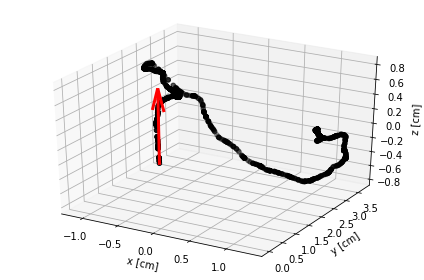

In [3]:
# Visualize a raw recoil simulation 

# Select recoil index
i = 12

# Raw simulations start in the origin and the initial direction is along the z-axis
mytools.plot_track_dir(x_points = df.iloc[i]['x'], y_points = df.iloc[i]['y'], z_points = df.iloc[i]['z'], direction = np.array([0,0,1]), start = np.array([0,0,0])  )


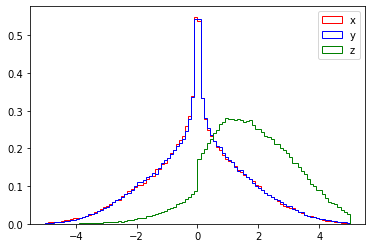

In [4]:
# Extract and combine all spacial info
all_x = np.concatenate(df.x)
all_y = np.concatenate(df.y)
all_z = np.concatenate(df.z)

# Plot spacial info to ensure x and y distributions are equivalent
plt.figure()
datax = plt.hist(all_x, bins=100, density=True, range =(-5,5), histtype='step',color='r',label ='x')
datay = plt.hist(all_y, bins=100, density=True, range =(-5,5), histtype='step',color='b',label ='y')
dataz = plt.hist(all_z, bins=100, density=True, range =(-5,5), histtype='step',color='g',label ='z')
plt.legend()


The distribution above is as expected. Electrons are initially travelling in z but are otherwise symmetric in x and y.

# Apply Diffusion to the simulations

In [5]:
# Total sigma [cm] used for diffusion
sigma = 466.0 * float(1e-4)

df_diff = pd.DataFrame(columns = ['x', 'y', 'z'])

for index, row in df.iterrows():

    # diffuse x/y/z positions
	x_new = row['x']+(sigma*np.random.normal(size=len(row['x'])))
	y_new = row['y']+(sigma*np.random.normal(size=len(row['y'])))
	z_new = row['z']+(sigma*np.random.normal(size=len(row['z'])))

	# Store transformed positions and new dataframe
	df_diff = df_diff.append({'x' : x_new, 'y' : y_new, 'z' : z_new }, ignore_index = True)

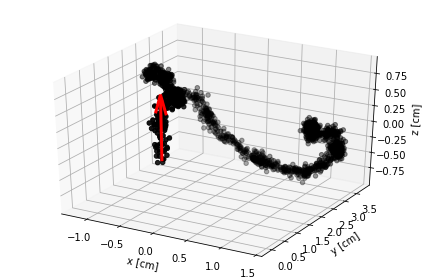

In [6]:
# Visualize a diffused recoil simulation 

# Select recoil index
i = 12

# Raw simulations start in the origin and the initial direction is along the z-axis
mytools.plot_track_dir(x_points = df_diff.iloc[i]['x'], y_points = df_diff.iloc[i]['y'], z_points = df_diff.iloc[i]['z'], direction = np.array([0,0,1]), start = np.array([0,0,0])  )


# Rotate simulations to a random direction

In [7]:
df_rot = pd.DataFrame(columns = ['x', 'y', 'z', 'dir'])

for index, row in df_diff.iterrows():

    x_new = []
    y_new = []
    z_new = []

    # Determine random direction to rotate to
    to_dir = mytools.random_three_vector()

    # rotate all positions
    for x,y,z in zip(row['x'],row['y'],row['z']):

        charge = TVector3(x,y,z)

        #Rotate
        charge.RotateY(to_dir.Theta())
        charge.RotateZ(to_dir.Phi())

        x_new += [charge[0]]
        y_new += [charge[1]]
        z_new += [charge[2]]

    
    # Store transformed positions and new dataframe
    df_rot = df_rot.append({'x' : np.array(x_new), 'y' : np.array(y_new), 'z' : np.array(z_new), 'dir': np.array([to_dir[0],to_dir[1],to_dir[2]])}, ignore_index = True)

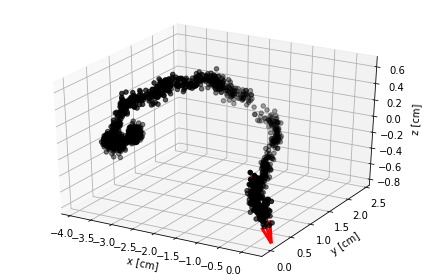

In [8]:
# Visualize a diffused and randomly rotated recoil simulation 

# Select recoil index
i = 12

# Raw simulations start in the origin and the initial direction is now provided in the dataframe
mytools.plot_track_dir(x_points = df_rot.iloc[i]['x'], y_points = df_rot.iloc[i]['y'], z_points = df_rot.iloc[i]['z'], direction = df_rot.iloc[i]['dir'], start = np.array([0,0,0])  )


# Mean-center the simulations

In [9]:
df_processed = pd.DataFrame(columns = ['x', 'y', 'z', 'dir','offset'])

for index, row in df_rot.iterrows():

	mean_x = np.mean(row['x'])
	mean_y = np.mean(row['y'])
	mean_z = np.mean(row['z'])

    # diffuse x/y/z positions
	x_new = row['x']-mean_x
	y_new = row['y']-mean_y
	z_new = row['z']-mean_z

	# Store transformed positions in new dataframe
	df_processed = df_processed.append({'x' : x_new, 'y' : y_new, 'z' : z_new, 'dir': row.dir, 'offset': -1.0*np.array( [mean_x, mean_y, mean_z] ) }, ignore_index = True)



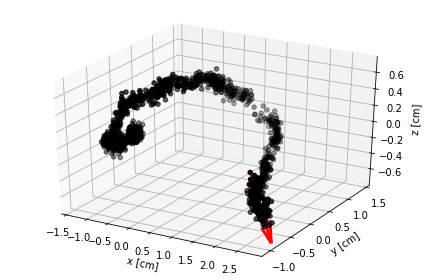

In [10]:
# Visualize a fully processed recoil simulation 

# Select recoil index
i = 12

# Raw simulations start in the origin and the initial direction is now provided in the dataframe
mytools.plot_track_dir(x_points = df_processed.iloc[i]['x'], y_points = df_processed.iloc[i]['y'], z_points = df_processed.iloc[i]['z'], direction = df_processed.iloc[i]['dir'], start = df_processed.iloc[i]['offset']  )


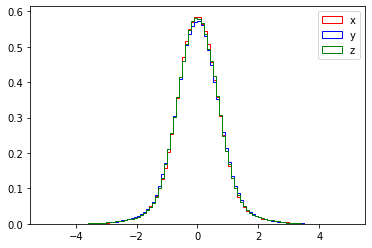

In [11]:
# Extract and combine all spacial info
all_x = np.concatenate(df_processed.x)
all_y = np.concatenate(df_processed.y)
all_z = np.concatenate(df_processed.z)

# Plot spacial info to ensure dataset is isotropic
plt.figure()
datax = plt.hist(all_x, bins=100, density=True, range =(-5,5), histtype='step',color='r',label ='x')
datay = plt.hist(all_y, bins=100, density=True, range =(-5,5), histtype='step',color='b',label ='y')
dataz = plt.hist(all_z, bins=100, density=True, range =(-5,5), histtype='step',color='g',label ='z')
plt.legend()


The distribution above is as expected. The data is now isotropic.

# Pixelize the simulations (convert into a tensor)

In [12]:
# for now we test on one track
track = df_processed.iloc[i]

# Here a define the pixel grid parameters
# x/y/z length being kept in cm
eff_l = 3.0
# Voxel size in cm
vox_l = 0.05
# Number of voxels along 1 dim
Npix = round(eff_l*2/vox_l) 
# Tensor dimensions, there is an extra dimension for color which is not used
dim = (1,Npix,Npix,Npix)


if np.max(track['x']) >= eff_l or np.min(track['x']) < -eff_l or np.max(track['y']) >= eff_l or np.min(track['y']) < -eff_l or np.max(track['z']) >= eff_l or np.min(track['z']) < -eff_l:
	print("track not contained")

# Initialize empty dense tensor
voxelgrid = np.zeros(dim).astype('uint8')

# Loop the x, y, z positions in the recoil and fill in the dense tensor
for x,y,z in zip(track['x'],track['y'],track['z']):
	voxelgrid[0][int((x+eff_l)/vox_l)][int((y+eff_l)/vox_l)][int((z+eff_l)/vox_l)] += 1
	
# Convert to pytorch tensor
voxelgrid = torch.tensor(voxelgrid)

# Convert to sparse pytorch tensor
vg = voxelgrid.to_sparse()

# store the label
label = track['dir']
offset = track['offset']


In [13]:
# Save the test
torch.save(vg,'./test_tensor.pt')
torch.save(torch.Tensor(label),'./test_label.pt')
torch.save(torch.Tensor(offset),'./test_offset.pt')

In [14]:
# Load the test
tensor = torch.load('./test_tensor.pt')
ans = torch.load('./test_label.pt')
off = torch.load('./test_offset.pt')

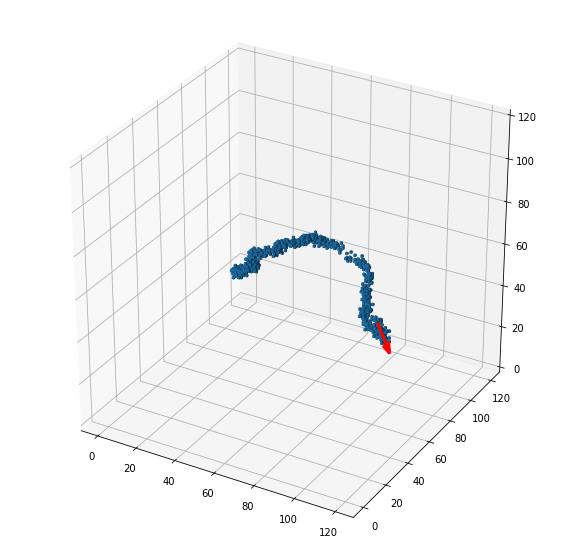

In [15]:
# Plot the tensor

# Convert to a dense numpy array
dense_tensor = tensor.to_dense().numpy()

# Convert direction and offset to numpy arrays
Ans = ans.numpy()
Off = off.numpy()


mytools.plot_tensor(tensor = dense_tensor, start = Off, direction = Ans, eff_l = eff_l, vox_l = vox_l)


